# <center> Movie Review Sentiment Analysis </center>
## <center> Classify the sentiment of sentences from the Rotten Tomatoes dataset </center>

##  Contents

In the following we do the following points:
-  introduce the dataset
-  a bit of visualization
-  Deep Learning models:  preprocessing, LSTM, GRU, Bi-directionnal
-  Baselines: should come first but less relevant for today !
      
---

* [Introduction](#introduction)
* [Exploratory Data Analysis](#eda)
---
* [Different Machine Learning Models ](#DL)
  *  [Preprocessing](#lstm)
  *  [LSTM model](#lstm)
  *  [GRU model ](#gru)
  *  [Bidirectional-GRU model](#bgru)
  *  [ CNN model ](#cnn)
---
* [Machine Learning Models without RNN (baselines)](#ml)
  *  [N-Grams Method](#N-Grams)


---


<a id='introduction'></a>
## <center> Introduction </center>

From https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/overview/description


The Rotten Tomatoes movie review dataset is a corpus of movie reviews used for sentiment analysis, originally collected by Pang and Lee [1]. In their work on sentiment treebanks, Socher et al. [2] used Amazon's Mechanical Turk to create fine-grained labels for all parsed phrases in the corpus. This competition presents a chance to benchmark your sentiment-analysis ideas on the Rotten Tomatoes dataset. You are asked to label phrases on a scale of five values: negative, somewhat negative, neutral, somewhat positive, positive. Obstacles like sentence negation, sarcasm, terseness, language ambiguity, and many others make this task very challenging.




![treebank.png](treebank.png)



More on the sentiment treebank https://nlp.stanford.edu/sentiment/treebank.html

In [25]:
# imports
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Text datasets

Working with NLP datasets (reviews, captions, etc.) typically involves an important preprocessing of the data. 


When working with images, the observations are naturally transformed into arrays (of size number of pixels * 3) with numerical values (in [0;255] for example).

<a id='eda'></a>
## <center>Exploratory Data Analysis </center>
Basic exploration of data to check labels , the number of phrases for each label and average phrase length in the each sentiment.

In [26]:
PATH = 'input/'
os.listdir(PATH)

['.DS_Store', 'sampleSubmission.csv', 'test.tsv', 'train.tsv']

In [27]:
train = pd.read_csv('input/train.tsv', sep = '\t')
test  = pd.read_csv('input/test.tsv', sep = '\t')

sub = pd.read_csv('input/sampleSubmission.csv' , sep = ',')

In [28]:
train.head(20)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


###  Print the full sentence for the first element in the train set. Is it a positive review in your opinion ?

In [29]:
train.Phrase[0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [30]:
a= train.Phrase[train.SentenceId == 12]

#### Q1. Print the columns names for train

In [31]:
train.columns

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')

#### Q2. How many phrases are there in the dataset?

In [32]:
train.shape

(156060, 4)

#### Q3. How many reviews are there originally in the dataset?

In [33]:
np.unique(np.array(train.SentenceId))

array([   1,    2,    3, ..., 8542, 8543, 8544])

#### Q4. Print  the first elements of the test dataset

In [34]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


#### Q5. What do you think about the dataset ? 

We can make at least the following remarks.
- one sentence led to multiple phrases: the parse tree above was used to get multiple phrases 
- it is unlikely that we can get 100% accuracy: a same review could be given multiple scores: there is randomness in the review to score mapping

In [35]:
class_count = train['Sentiment'].value_counts()
class_count

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

#### Q6: Do we have the labels for the test set? Why? How can we evaluate our methods?
- We do not get the labels, because it is a kaggle dataset: we only observe X_test and not y_test
- We could submit on kaggle to get score
- We can split the train set into a train set and a validation/local test set. We adopt this last solution.


We keep X_test in the processing: if some of you want to upload solutions on kaggle to evaluate their scores, you can use the cells marked with # If you want to upload on kaggle

#### Q7. What do we need to be careful about when splitting the train set?

- our rows are **not** independent !
- we need to put different **sentences** into the train and validation set: for a sentence, all phrases derived from this sentence will be put together.

### The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

Text(0, 0.5, 'Number of reviews ')

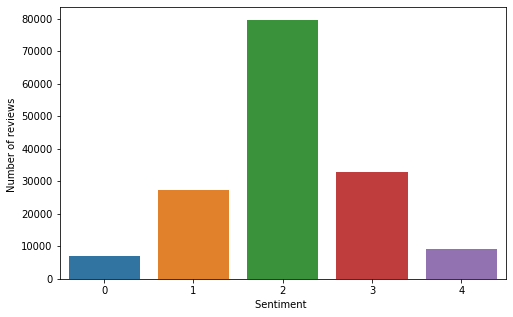

In [36]:
x = np.array(class_count.index)
y = np.array(class_count.values)
plt.figure(figsize=(8, 5))
sns.barplot(x, y)
plt.xlabel('Sentiment ')
plt.ylabel('Number of reviews ')

In [37]:
print('Number of sentences in training set:',len(train['SentenceId'].unique()))
print('Number of sentences in test set:',len(test['SentenceId'].unique()))
print('Average words per sentence in train:',train.groupby('SentenceId')['Phrase'].count().mean())
print('Average words per sentence in test:',test.groupby('SentenceId')['Phrase'].count().mean())

Number of sentences in training set: 8529
Number of sentences in test set: 3310
Average words per sentence in train: 18.297572986282095
Average words per sentence in test: 20.027794561933536


### Using Word Clouds to see the higher fequency words from each sentiment

For the following cells, you need to use the wordcloud package.

- Installation guidelines here https://github.com/amueller/word_cloud
- Blog post describing the package here https://peekaboo-vision.blogspot.com/2012/11/a-wordcloud-in-python.html

In [38]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)


def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1  # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

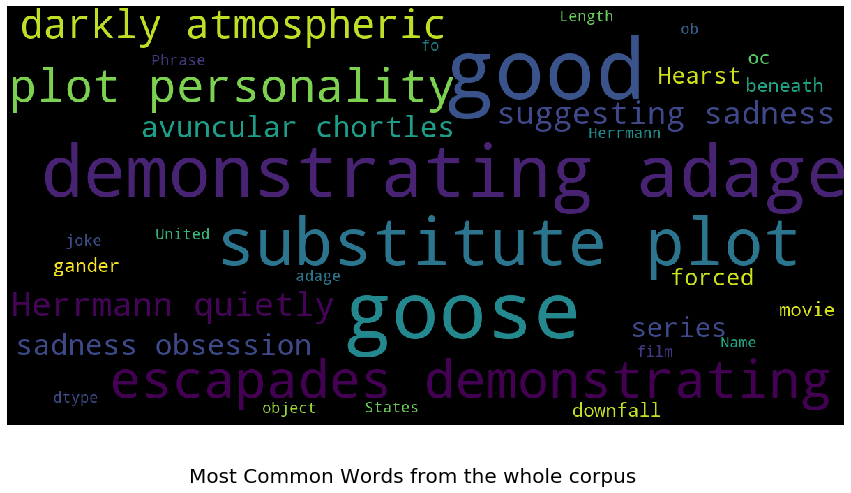

In [39]:
show_wordcloud(train['Phrase'], 'Most Common Words from the whole corpus')

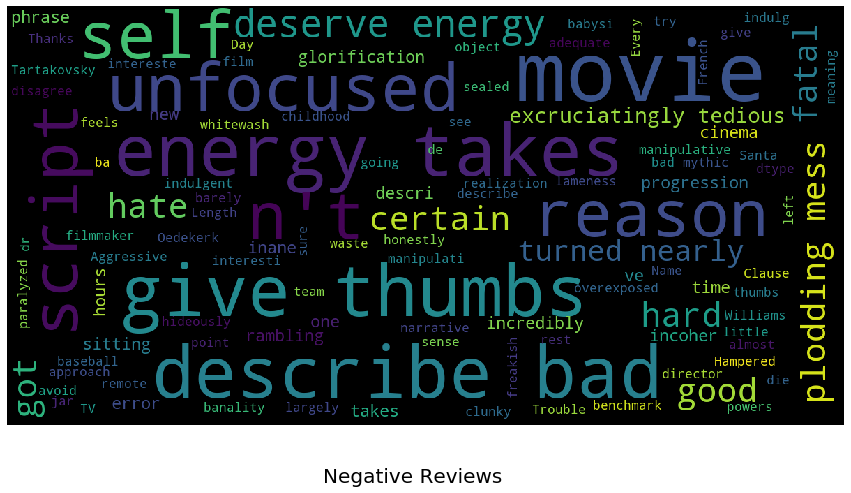

In [40]:
show_wordcloud(train[train.Sentiment == 0]['Phrase'],'Negative Reviews')

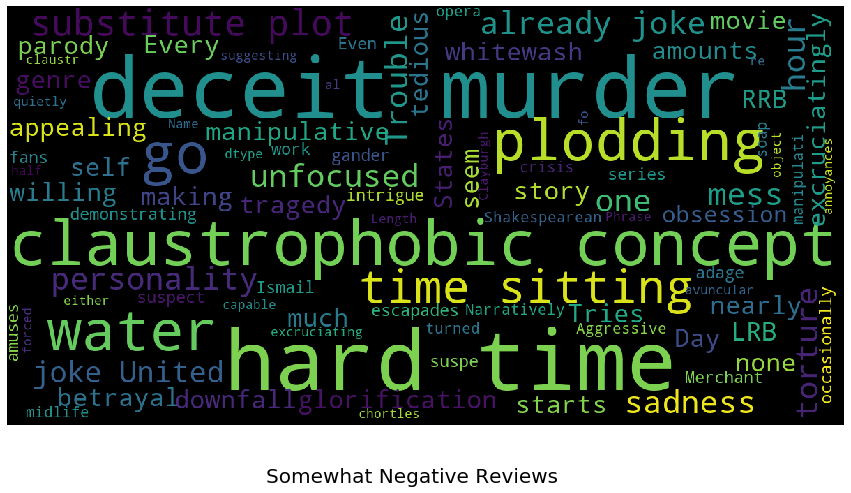

In [41]:
show_wordcloud(train[train['Sentiment'] == 1]['Phrase'], 'Somewhat Negative Reviews')

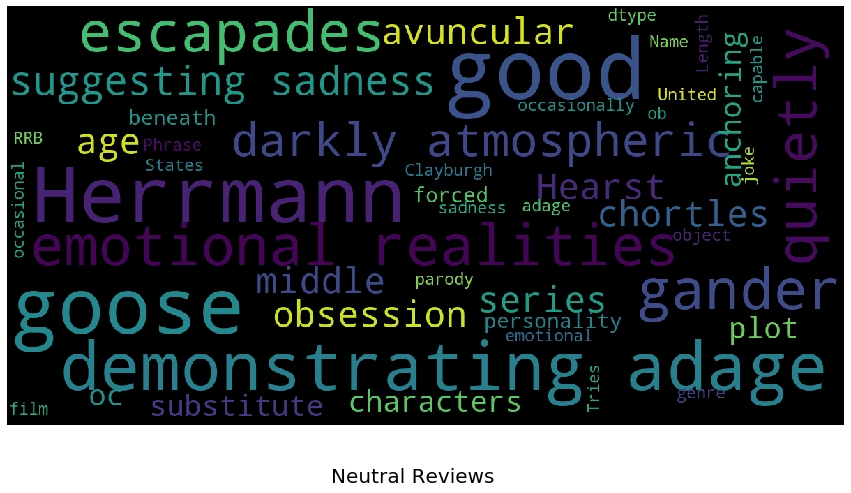

In [42]:
show_wordcloud(train[train['Sentiment'] == 2]['Phrase'],'Neutral Reviews')

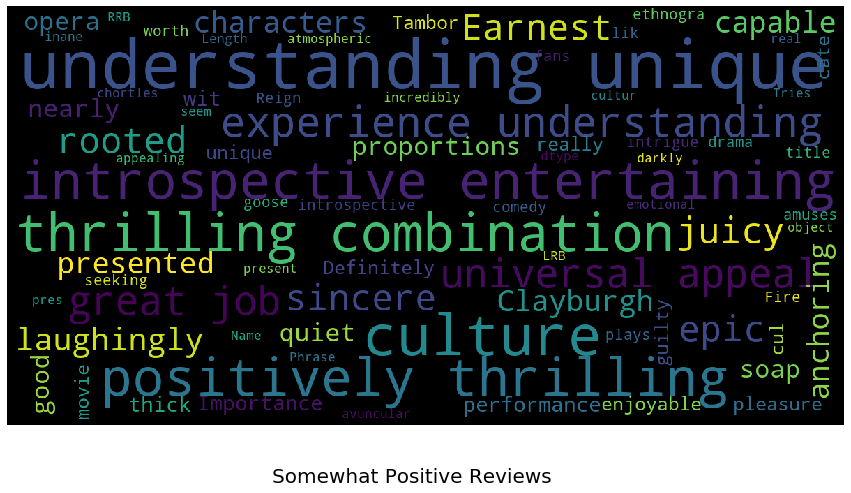

In [43]:
show_wordcloud(train[train['Sentiment'] == 3]['Phrase'],'Somewhat Positive Reviews')

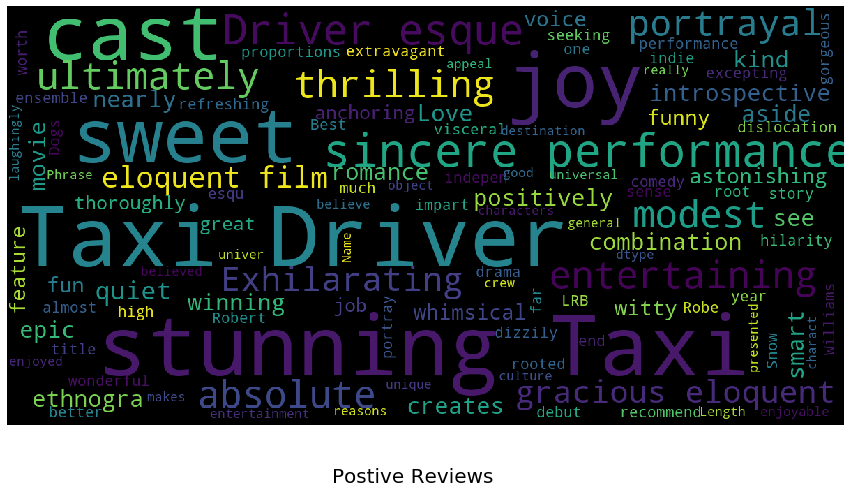

In [44]:
show_wordcloud(train[train['Sentiment'] == 4]['Phrase'],'Postive Reviews')

#### Q8: Comment on the previous visualizations.

---
<a id='DL'></a>
# <center> ''Deep'' Learning models: RNN</center>

The goal of this part is to implement typical Recurrent Neural Networks: 
- based on LSTM
- based on GRU
- based on Bi-directional GRU
- based on CNN

For convenience, we use keras. For those wondering what the main differences are, you can have a look at https://towardsdatascience.com/keras-vs-pytorch-for-deep-learning-a013cb63870d

In [115]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,GRU,LSTM,Embedding
from keras.optimizers import Adam
from keras.layers import SpatialDropout1D,Dropout,Bidirectional,Conv1D,GlobalMaxPooling1D,MaxPooling1D,Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

## <center> 1. Preprocessing </center>

The preprocessing part is very often important for natural language datasets. As we are not dealing with quantitative variables but with words in a vocabulary, we need to be careful.

**You should not spend more than 20 minutes on this part** All the details are given, and many visualizations are provided, so that you can come back afterwards to understand with more details.

We have the following steps:
- a.  transform y to categories.
- b. make the train validation split very carefully.
- c. transform lists of sentences into an array:
  - Each word is mapped to a number. 
  - Lists of numbers are padded with 0 or truncated to fit in an array

###  a. make the train validation split very carefully.

#### Q9: Split the train set into X_train and X_val, with labels Y_train and Y_val.
Remember that we need to separate sentences !

In [116]:
# Toy example: use only the first 10 unique SentenceId to split
from sklearn.model_selection import train_test_split
Sent_train, Sent_val = train_test_split(train.SentenceId.unique()[0:10],test_size = 0.20)
Sent_train, Sent_val

# before was 
# X_train , X_val , Y_train , Y_val = train_test_split(train.Phrase,y,test_size = 0.20)
# but that seems super bad !!
# Try for example
# X_train , X_val , Y_train , Y_val = train_test_split(train.Phrase[0:10],y[0:10],test_size = 0.20)
# X_val.head(),X_train.head()

(array([5, 9, 2, 7, 6, 8, 3, 4]), array([10,  1]))

#### Q9.1: Plot the train dataframe corresponding to the sentence_Id that are in the Sent_train.
You can use the ```isin``` function.

In [117]:
train[train.SentenceId.isin(Sent_train)][0:30]

,PhraseId,SentenceId,Phrase,Sentiment
63,64,2,"This quiet , introspective and entertaining in...",4
64,65,2,"This quiet , introspective and entertaining in...",3
65,66,2,This,2
66,67,2,"quiet , introspective and entertaining indepen...",4
67,68,2,"quiet , introspective and entertaining",3
68,69,2,quiet,2
69,70,2,", introspective and entertaining",3
70,71,2,introspective and entertaining,3
71,72,2,introspective and,3
72,73,2,introspective,2


#### Q.9.2: Create 
- X_train
- X_val
- Y_train
- Y_val

In [118]:
Sent_train, Sent_val = train_test_split(train.SentenceId.unique(),
                                        test_size=0.20)
Sent_train, Sent_val

X_train = train.Phrase.values[train.SentenceId.isin(Sent_train)]
X_val = train.Phrase.values[train.SentenceId.isin(Sent_val)]
Y_train = train.Sentiment.values[train.SentenceId.isin(Sent_train)]
Y_val = train.Sentiment.values[train.SentenceId.isin(Sent_val)]

Phrase0 = X_train[0]

In [119]:
Phrase0

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

###  b.  transform y to categories.


#### Q10: transform the target into a categorical variable

In [120]:
from keras.utils import to_categorical
Y_train = to_categorical(Y_train) 
Y_val = to_categorical(Y_val) #TODO
Y_train

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [121]:
from sklearn.utils import shuffle

X_train, Y_train= shuffle(X_train, Y_train)

In [122]:
X_train

array(["it 's also disappointing to a certain degree .",
       'a cipher , played by an actress who smiles and frowns',
       "raison d'etre", ..., 'have chosen a fascinating subject matter',
       'produced by Jerry Bruckheimer and directed by Joel Schumacher',
       'wankery'], dtype=object)

### c. transform lists of sentences into an array:
In the following, we now tokenize the train and test set

In [124]:
max_features = 13000
max_words = 50
num_classes = 5

#### Q11: Understand the follwoing cells !

In [125]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_val   = tokenizer.texts_to_sequences(X_val)
type(X_train)

list

**Comment**: the tokenizer maps each Phrase into a sequence

In [126]:
print(X_train[0])
print(Phrase0)

[10, 6, 174, 1955, 5, 2, 757, 1545]
A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .


**Comment**: We can check the correspondance to the sentence using the ```word_index```

In [127]:
tokenizer.word_index

{'the': 1,
 'a': 2,
 'of': 3,
 'and': 4,
 'to': 5,
 "'s": 6,
 'in': 7,
 'is': 8,
 'that': 9,
 'it': 10,
 'as': 11,
 'with': 12,
 'for': 13,
 'its': 14,
 'film': 15,
 'an': 16,
 'movie': 17,
 'this': 18,
 'but': 19,
 'be': 20,
 'on': 21,
 'you': 22,
 "n't": 23,
 'more': 24,
 'his': 25,
 'by': 26,
 'one': 27,
 'at': 28,
 'about': 29,
 'not': 30,
 'than': 31,
 'or': 32,
 'all': 33,
 'from': 34,
 'like': 35,
 'have': 36,
 'has': 37,
 'so': 38,
 'are': 39,
 'out': 40,
 "'": 41,
 'story': 42,
 'up': 43,
 'rrb': 44,
 'who': 45,
 'good': 46,
 'too': 47,
 'into': 48,
 'most': 49,
 'lrb': 50,
 'time': 51,
 'characters': 52,
 'if': 53,
 'what': 54,
 'their': 55,
 'no': 56,
 'much': 57,
 'i': 58,
 "''": 59,
 'your': 60,
 'can': 61,
 'just': 62,
 'life': 63,
 'some': 64,
 'comedy': 65,
 'does': 66,
 'little': 67,
 'way': 68,
 'will': 69,
 'any': 70,
 'well': 71,
 'funny': 72,
 'very': 73,
 'even': 74,
 'director': 75,
 'been': 76,
 'new': 77,
 'movies': 78,
 'which': 79,
 'make': 80,
 'do': 81,
 'h

**Comment** the words were sorted by number of occurences

In [128]:
tokenizer.word_counts

OrderedDict([('it', 9305),
             ("'s", 13546),
             ('also', 550),
             ('disappointing', 53),
             ('to', 18227),
             ('a', 29396),
             ('certain', 129),
             ('degree', 67),
             ('cipher', 31),
             ('played', 54),
             ('by', 3068),
             ('an', 5277),
             ('actress', 139),
             ('who', 1912),
             ('smiles', 31),
             ('and', 25437),
             ('frowns', 12),
             ('raison', 13),
             ("d'etre", 13),
             ('sylvie', 5),
             ('testud', 20),
             ('is', 10576),
             ('icily', 7),
             ('brilliant', 182),
             ('goldmember', 17),
             ('funny', 1212),
             ('enough', 1003),
             ('justify', 72),
             ('the', 40757),
             ('embarrassment', 41),
             ('of', 26141),
             ('bringing', 44),
             ('barf', 20),
             ('bag', 69),
    

Also for the test if you want to evaluate on kaggle

In [129]:
X_test = tokenizer.texts_to_sequences(test['Phrase'])
X_test = pad_sequences(X_test, maxlen=max_words)

In [130]:
len(X_test)

66292

Finally, we pad sequences in order to limit the length of any sequence to a maximal lenght

In [131]:
for i in range (10):
    print(len(X_train[i]))

8
10
2
5
16
3
3
2
17
7


In [132]:
X_train = pad_sequences(X_train, maxlen=max_words)
X_val = pad_sequences(X_val, maxlen=max_words)
X_test = pad_sequences(X_test, maxlen=max_words)

In [133]:
X_train.shape

(124754, 50)

In [134]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,   10,    6,
        174, 1955,    5,    2,  757, 1545], dtype=int32)

We see that in most situations, padding corresponds to adding zeros at the beginning. If one review is particularly long, it results in truncation.

See the documentation:
- pad_sequence : https://keras.io/preprocessing/sequence/
- tokenizer : https://keras.io/preprocessing/text/

### Q12: Before starting the implementation of the networks, make sure you understand what type of data we are dealing with:
- what is X_train, y_train, etc.
- what are there respective sizes
- are the values floats, integers ?
- what do those words correspond to
- have we preserved the order of the sequence ?

Write down your answers !!!


<a id='lstm'></a>
## <center>2. LSTM</center>


The first neural network we consider uses LSTM.
See [Understanding LSTM Networks -- colah's blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) for an excellent description of LSTM

### 1. Q14 : Create of model with the Sequential function composed of :
- an Embedding layer (Turns positive integers (indexes) into dense vectors of fixed size)
  - how many words at most can we embed (first argument)
  - we embed those words in dimension 100 (arbitrary choice, often "enough")
  - use mask_zero=True
- an LSTM layer:
  - with 64 units, 
  - dropout of 0.5, 
  - return_sequences=True
- an LSTM layer:
  - with 32 units, 
  - dropout of 0.5, 
  - return_sequences=False
- a dense Layer :
  - what should be the dimension of the output?
  - what should be the activation?
  


In [135]:
model3_LSTM = Sequential()
model3_LSTM.add(Embedding(max_features, 50, mask_zero=True))  ## Todo
model3_LSTM.add(LSTM(64, dropout=0.4, return_sequences=True))  ## Todo 
model3_LSTM.add(LSTM(32, dropout=0.5, return_sequences=False)) # # Todo
model3_LSTM.add(Dense(num_classes, activation='softmax'))      ## Todo



### 2. Q15: Compile the model.

- Use the binary cross entropy for the loss
- Use Adam optimizer with learning rate  0.001
- Use accuracy for the metrics

In [136]:
model3_LSTM.compile(loss='binary_crossentropy',
                    optimizer=Adam(lr=0.001),
                    metrics=['accuracy'])


- Print the summary of the model

In [137]:
model3_LSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 50)          650000    
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 64)          29440     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 165       
Total params: 692,021
Trainable params: 692,021
Non-trainable params: 0
_________________________________________________________________


Comment on the number of parameters:
- Embedding: #params = max_features x dim Embedding = 13000 x 100 = 1 300 000
- LSTM : see e.g., <a href= "https://stackoverflow.com/questions/38080035/how-to-calculate-the-number-of-parameters-of-an-lstm-network"> this post <a\>. $$\text{Nb params} = 4 * ((\text{size_of_input} + 1) * \text{size_of_output} + \text{size_of_output}^2).$$ 

Here $4*64*(100+64+1) = 42240$

- Dense= (output dimension of previous layer +1) x (output) (the +1 is for the biases). Here 32x5+5=165

### 3. Fit the model
- Use 2 epochs
- Use Batch_size = 128


In [138]:
batch_size = 128
epochs = 1

#### Q16: Fit the model:
You will provide
- X_train, y_train
- validation_data
- epochs
- batch_size
- verbose=1

In [139]:
%%time
history3=model3_LSTM.fit(X_train, Y_train, validation_data=(X_val, Y_val),epochs=epochs, batch_size=batch_size, verbose=1)

Train on 124754 samples, validate on 31306 samples
Epoch 1/1
124754/124754 [==============================] - 379s 3ms/step - loss: 0.3757 - acc: 0.8403 - val_loss: 0.3547 - val_acc: 0.8435
CPU times: user 29min 23s, sys: 15min 55s, total: 45min 18s
Wall time: 6min 20s


#### Q17: Answer the following questions
- What is the final accuracy of the model?
- How is this accuracy defined ?
- Do you think we can hope that the model accuracy can reach 100% ?

|Max_words | 50 | **10**| 50|
|---|---|---|---|
|Dim_embedding | 100 | 100| 50|
|Time| 6min 23| **1min57**| 6min 20| 
|Accuracy_val| 0.8492 | 0.8454| 0.8435 |

Comments:
- the time complexity depends linearly on the length of the input sequence: indeed, we need to **sequentially** compute the result of the LSTM units. No parallelization can me made with respect to the length of the sequence.
- dimension 100 is typically a "correct" dimension for the embeddings (large enough to have meaningful representations.
- reducing the dimension of the embedding does not really change the training time

In [90]:
# if you want to upload on kaggle
y_pred3=model3_LSTM.predict_classes(X_test, verbose=1)
sub.Sentiment=y_pred3
sub.to_csv('sub3_LSTM.csv',index=False)
sub.head()

66292/66292 [==============================] - 130s 2ms/step


,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,3
4,156065,3


<a id='gru'></a>
## <center>3. GRU</center>
#### Q18: create GRu architecture, compile the model, fit it
We now do the same operations again using a GRU unit instead of the LSTM unit. All the rest of the architecture remains unchanged.

You can try with loss ```categorical_crossentropy``` or ```binary_crossentropy```

In [172]:
model_GRU=Sequential()
model_GRU.add(Embedding(max_features,100,mask_zero=True))
model_GRU.add(GRU(64,dropout=0.4,return_sequences=True))
model_GRU.add(GRU(32,dropout=0.5,return_sequences=False))
model_GRU.add(Dense(num_classes,activation='softmax'))
model_GRU.compile(loss='categorical_crossentropy',optimizer=Adam(lr = 0.001),metrics=['accuracy'])
model_GRU.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1300000   
_________________________________________________________________
gru_1 (GRU)                  (None, None, 64)          31680     
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                9312      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 165       
Total params: 1,341,157
Trainable params: 1,341,157
Non-trainable params: 0
_________________________________________________________________


In [173]:
%%time
history1=model_GRU.fit(X_train, Y_train, validation_data=(X_val, Y_val),epochs=epochs, batch_size=batch_size, verbose=1)

Train on 124840 samples, validate on 31220 samples
Epoch 1/1
124840/124840 [==============================] - 362s 3ms/step - loss: 1.0275 - acc: 0.5924 - val_loss: 1.0003 - val_acc: 0.6146
CPU times: user 25min 48s, sys: 17min 16s, total: 43min 5s
Wall time: 6min 3s


In [ ]:
# If you want to upload on kaggle
y_pred1=model_GRU.predict_classes(X_test, verbose=1)
sub.Sentiment=y_pred1
sub.to_csv('sub1_GRU.csv',index=False)
sub.head()

#### Q19:  Answer the following questions
- What is the final accuracy of the model?
- Is there a difference between LSTM and GRU?

- Record the training time: go back and change the X_train:
  - divide the number of sentences by 2
OR  
  - change the length of the sequences to 200 instead of 50
What happens ?


In [ ]:
model2_GRU=Sequential()
model2_GRU.add(Embedding(max_features,100,mask_zero=True))
model2_GRU.add(GRU(64,dropout=0.4,return_sequences=True))
model2_GRU.add(GRU(32,dropout=0.5,return_sequences=False))
model2_GRU.add(Dense(num_classes,activation='sigmoid'))
model2_GRU.compile(loss='binary_crossentropy',optimizer=Adam(lr = 0.001),metrics=['accuracy'])
model2_GRU.summary()

In [ ]:
%%time
history2=model2_GRU.fit(X_train, Y_train, validation_data=(X_val, Y_val),epochs=epochs, batch_size=batch_size, verbose=1)

In [ ]:
# If you want to upload on kaggle
y_pred2 = model2_GRU.predict_classes(X_test, verbose=1)
sub.Sentiment = y_pred2
sub.to_csv('sub2_GRU.csv', index=False)
sub.head()

<a id='bgru'></a>
## <center>4. Bidirectional-GRU</center>

Only if more than one hour left: otherwise, skip to the baselines !

We now do the same operations again using a Bidirectional GRU unit instead of the LSTM unit. All the rest of the architecture remains unchanged.

In [ ]:
model4_BGRU = Sequential()
model4_BGRU.add(Embedding(max_features, 100, input_length=max_words))
model4_BGRU.add(SpatialDropout1D(0.25))
model4_BGRU.add(Bidirectional(GRU(64,dropout=0.4,return_sequences = True)))
model4_BGRU.add(Bidirectional(GRU(32,dropout=0.5,return_sequences = False)))
model4_BGRU.add(Dense(5, activation='sigmoid'))
model4_BGRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model4_BGRU.summary()

In [ ]:
%%time
history4=model4_BGRU.fit(X_train, Y_train, validation_data=(X_val, Y_val),epochs=epochs, batch_size=batch_size, verbose=1)

In [ ]:
y_pred4=model4_BGRU.predict_classes(X_test, verbose=1)
sub.Sentiment=y_pred4
sub.to_csv('sub4_BGRU.csv',index=False)
sub.head()

<a id='cnn'></a>
## <center>5.CNN</center>

Finally, you can also compare to the CNN model below.

In [ ]:
model5_CNN= Sequential()
model5_CNN.add(Embedding(max_features,100,input_length=max_words))
model5_CNN.add(Dropout(0.2))
model5_CNN.add(Conv1D(64,kernel_size=3,padding='same',activation='relu',strides=1))
model5_CNN.add(GlobalMaxPooling1D())
model5_CNN.add(Dense(128,activation='relu'))
model5_CNN.add(Dropout(0.2))
model5_CNN.add(Dense(num_classes,activation='sigmoid'))
model5_CNN.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model5_CNN.summary()

In [ ]:
%%time
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

history5=model5_CNN.fit(X_train, Y_train, validation_data=(X_val, Y_val),epochs=3, batch_size=batch_size, verbose=1,callbacks = [early_stop])

In [ ]:
y_pred5=model5_CNN.predict_classes(X_test, verbose=1)
sub.Sentiment=y_pred5
sub.to_csv('sub5_CNN.csv',index=False)
sub.head()

<a id='ml'></a>
## <center> Machine Learning Models without RNN (baselines) </center>


We are going to use the Natural Language Toolkit NLTK package https://www.nltk.org/

``NLTK is a leading platform for building Python programs to work with human language data. It provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for 
- classification
- tokenization
- stemming
- tagging 
- parsing
- semantic reasoning
- wrappers for industrial-strength NLP libraries
- etc.

In [177]:
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
tokenizer = TweetTokenizer()
np.set_printoptions(precision=2)

### Q20: What would be the simplest approach without using RNN. 
- propose an approach using words counts
- do you think it would work well?
- would that take the order of words into account?

--- 


- Do we take the order of words into account using LSTM
- Do we take the order of words into account using CNN


Give examples of groups of words that matter in reviews 

<a id=' N-Grams'></a>
##  <center>1.N-Grams</center>

We first vecorize the training (and testing) vectors:
- we first make a list of all Phrases, in the variable ```full_text```
- we tokenize the full text, using n-grams (only  uni-grams an bi-grams) see https://en.wikipedia.org/wiki/N-gram, and Tfidf metric

We are going to detail the tokenization (how to obtain a huge sparse matrix with interesting values) in detail:
- shall we use the words, combination of words, etc.
- shall we use counts ? In your opinion, which word is the most frequent? is that meaningful?

In [178]:
full_text = list(train['Phrase'].values) + list(test['Phrase'].values)
full_text

['A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .',
 'A series of escapades demonstrating the adage that what is good for the goose',
 'A series',
 'A',
 'series',
 'of escapades demonstrating the adage that what is good for the goose',
 'of',
 'escapades demonstrating the adage that what is good for the goose',
 'escapades',
 'demonstrating the adage that what is good for the goose',
 'demonstrating the adage',
 'demonstrating',
 'the adage',
 'the',
 'adage',
 'that what is good for the goose',
 'that',
 'what is good for the goose',
 'what',
 'is good for the goose',
 'is',
 'good for the goose',
 'good',
 'for the goose',
 'for',
 'the goose',
 'goose',
 'is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .',
 'is also good for the gander , some of which occasionally amuses but none of 

### Example on a tiny corpus
#### Q20.1: count the words in the small corpus below 
- does syntax matter?
- what is the format of X after the fit_transform
- use ```X_count.todense()``` to get back a dense matrix. What is the drawback of this operation?


In [179]:
corpus = [
    'This is the first document.',
    'The document is the second document!!!',
    'And this is the third one on Patagonia.',
    'Is this the first doCUmENT?',
]

counter = CountVectorizer()
X_count = counter.fit_transform(corpus).todense()


print(counter.get_feature_names(), '\n')
print(X_count, '\n')

print(sum(X_count))

['and', 'document', 'first', 'is', 'on', 'one', 'patagonia', 'second', 'the', 'third', 'this'] 

[[0 1 1 1 0 0 0 0 1 0 1]
 [0 2 0 1 0 0 0 1 2 0 0]
 [1 0 0 1 1 1 1 0 1 1 1]
 [0 1 1 1 0 0 0 0 1 0 1]] 

[[1 4 2 4 1 1 1 1 5 1 3]]


#### Q21: Which is the most frequent word?

In [180]:
i = np.argmax(np.sum(X_count,0))
counter.get_feature_names()[i]

'the'

#### Instead of a simple count, we use de **tfidf** transform: it computes a kind of **relative importance of words**.

See for example:
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
- https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [181]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names(), '\n')
print(X.todense())

['and', 'document', 'first', 'is', 'on', 'one', 'patagonia', 'second', 'the', 'third', 'this'] 

[[0.   0.45 0.56 0.37 0.   0.   0.   0.   0.37 0.   0.45]
 [0.   0.64 0.   0.26 0.   0.   0.   0.5  0.52 0.   0.  ]
 [0.41 0.   0.   0.21 0.41 0.41 0.41 0.   0.21 0.41 0.26]
 [0.   0.45 0.56 0.37 0.   0.   0.   0.   0.37 0.   0.45]]


In [182]:
vectorizer.get_feature_names()[np.argmax(np.sum(X,0))]

'document'

#### Q22: Print all bigrams


In [183]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names(), '\n')

['and', 'and this', 'document', 'document is', 'first', 'first document', 'is', 'is the', 'is this', 'on', 'on patagonia', 'one', 'one on', 'patagonia', 'second', 'second document', 'the', 'the document', 'the first', 'the second', 'the third', 'third', 'third one', 'this', 'this is', 'this the'] 



### Going back to the main dataset

In [184]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), tokenizer=tokenizer.tokenize)
full_text = list(train['Phrase'].values) + list(test['Phrase'].values)
vectorizer.fit(full_text)
train_vectorized = vectorizer.transform(train['Phrase'])
test_vectorized = vectorizer.transform(test['Phrase'])

In [185]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


- Do we take the order of words into account using unigrams + tfidf + . logistic regression
- Do we take the order of words into account using bigrams/trigrams + tfidf + . logistic regression

#### Q23: How many n_grams are there in the dataset?

In [186]:
train_vectorized

<156060x301627 sparse matrix of type '<class 'numpy.float64'>'
	with 2963106 stored elements in Compressed Sparse Row format>

In [187]:
y = train['Sentiment']

####  Q24: Split into train and validation

In [1]:
# Sent_train, Sent_val = train_test_split(train.SentenceId.unique(),test_size=0.20)
# Sent_train, Sent_val

# x_train = train.Phrase[train.SentenceId.isin(Sent_train)]
# x_val = train.Phrase[train.SentenceId.isin(Sent_val)]
# y_train = train.Sentiment[train.SentenceId.isin(Sent_train)]
# y_val = train.Sentiment[train.SentenceId.isin(Sent_val)]

# Problem: not a coreect train validation split: need to do that before ! Doing it afterwards 
# is a problem because the matrix is either sparse or too big if we use ```.todense()```
x_train , x_val, y_train , y_val = train_test_split(train_vectorized,y,test_size = 0.2)

NameError: name 'train_test_split' is not defined

In [201]:
# train_vectorized.shape , train.SentenceId.isin(Sent_train).shape

((156060, 301627), (156060,))

In [203]:
# tvd= train_vectorized.todense()


In [ ]:
# tvd[train.SentenceId.isin(Sent_train)]

In [190]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.multiclass import OneVsRestClassifier

In [191]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

#### Q25: Train a Logistic Regression model and an SVM.

In [192]:
lr = LogisticRegression()
ovr = OneVsRestClassifier(lr)
ovr.fit(x_train,y_train)
print(classification_report(ovr.predict(x_val) , y_val))
print(accuracy_score(ovr.predict(x_val) , y_val ))

/Users/dieuleve/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.18      0.66      0.29       398
           1       0.32      0.56      0.41      3160
           2       0.91      0.65      0.76     22470
           3       0.42      0.59      0.49      4594
           4       0.22      0.67      0.33       590

    accuracy                           0.63     31212
   macro avg       0.41      0.63      0.46     31212
weighted avg       0.76      0.63      0.67     31212

0.633282070998334


In [193]:
svm = LinearSVC()
svm.fit(x_train,y_train)
print(classification_report( svm.predict(x_val) , y_val))
print(accuracy_score( svm.predict(x_val) , y_val ))

              precision    recall  f1-score   support

           0       0.39      0.49      0.44      1148
           1       0.48      0.56      0.52      4779
           2       0.82      0.73      0.77     18045
           3       0.53      0.58      0.55      5885
           4       0.42      0.54      0.47      1355

    accuracy                           0.66     31212
   macro avg       0.53      0.58      0.55     31212
weighted avg       0.68      0.66      0.66     31212

0.6559656542355504


In [194]:
estimators = [ ('svm',svm) , ('ovr' , ovr) ]
clf = VotingClassifier(estimators , voting='hard')
clf.fit(x_train,y_train)
print(classification_report( clf.predict(x_val) , y_val))
print(accuracy_score( clf.predict(x_val) , y_val ))

/Users/dieuleve/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.40      0.49      0.44      1167
           1       0.50      0.55      0.52      4945
           2       0.86      0.69      0.76     20165
           3       0.41      0.61      0.49      4373
           4       0.22      0.69      0.33       562

    accuracy                           0.65     31212
   macro avg       0.48      0.60      0.51     31212
weighted avg       0.71      0.65      0.67     31212

0.6463539664231706


<a id='en'></a>
## <center>Ensembling all the predictions</center>

In [ ]:
sub_all=pd.DataFrame({'model1':y_pred1,'model2':y_pred2,'model3':y_pred3,'model4':y_pred4,'model5':y_pred5,'model6':y_pred6,'model7':y_pred7})
pred_mode=sub_all.agg('mode',axis=1)[0].values
sub_all.head()

In [ ]:
pred_mode=[int(i) for i in pred_mode]
sub.Sentiment=pred_mode
sub.to_csv('ensemble_mode.csv',index=False)
sub.head()

Author: Aymeric DIEULEVEUT<br>
This notebook is adapted on Parth Rohilla's work, available at  https://www.kaggle.com/parth05rohilla/kernels<br>
Comments and cells were added and errors corrected